<a href="https://colab.research.google.com/github/acmenoita/Pratical-Machine-Learning/blob/Assignment-%232/Aquifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
from google.colab import files
uploaded = files.upload()

Saving aquifer_time_series.csv to aquifer_time_series.csv


In [4]:
def load_and_preprocess(filepath):
    df= pd.read_csv('aquifer_time_series.csv', parse_dates=['date'], dayfirst=True)

    # Create Year-Month column for grouping
    df['year_month'] = df['date'].dt.to_period('M')

    # Aggregate by month using median
    monthly = df.groupby('year_month').median().reset_index()

    # Convert year_month to datetime
    monthly['year_month'] = monthly['year_month'].dt.to_timestamp()

    return monthly

In [11]:
def create_lag_features(df, target_col='depth_to_groundwater_m', lags=12):
    features = []
    for i in range(lags + 1):  # K, K-1, ..., K-12
        lagged = df[['rainfall_mm', 'temperature_C', 'drainage_m3', 'river_hydrometry_m', target_col]].shift(i)
        lagged.columns = [f'{col}_lag{i}' for col in lagged.columns]
        features.append(lagged)

    all_features = pd.concat(features, axis=1)
    all_features['target'] = df[target_col]
    all_features['group'] = df['year_month'].dt.to_period('Q').astype(str)  # group by quarter/year

    all_features = all_features.dropna().reset_index(drop=True)
    return all_features

In [6]:
def build_model():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=42))
    ])
    return pipeline

In [7]:
def run_cross_validation(X, y, groups):
    model = build_model()
    gkf = GroupKFold(n_splits=5)
    scores = cross_val_score(model, X, y, cv=gkf, groups=groups, scoring='r2')
    print("Cross-validation R² scores:", scores)
    print("Mean R²:", np.mean(scores))

In [8]:
def final_fit_predict_plot(X, y):
    model = build_model()
    model.fit(X, y)
    y_pred = model.predict(X)

    plt.figure(figsize=(10,6))
    plt.plot(y.values, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title("Actual vs Predicted - depth_to_groundwater_m")
    plt.xlabel("Sample")
    plt.ylabel("Depth (m)")
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
def main():
    filepath = 'aquifer_time_series.csv'
    df = load_and_preprocess(filepath)
    data = create_lag_features(df)

    feature_cols = [col for col in data.columns if col.startswith(('rainfall', 'temperature', 'drainage', 'river', 'depth')) and 'target' not in col]
    X = data[feature_cols]
    y = data['target']
    groups = data['group']

    print("Running cross-validation...")
    run_cross_validation(X, y, groups)

    print("Fitting on full data and plotting predictions...")
    final_fit_predict_plot(X, y)

Running cross-validation...
Cross-validation R² scores: [0.95439899 0.95447812 0.99444904 0.9958152  0.93324404]
Mean R²: 0.9664770753031651
Fitting on full data and plotting predictions...


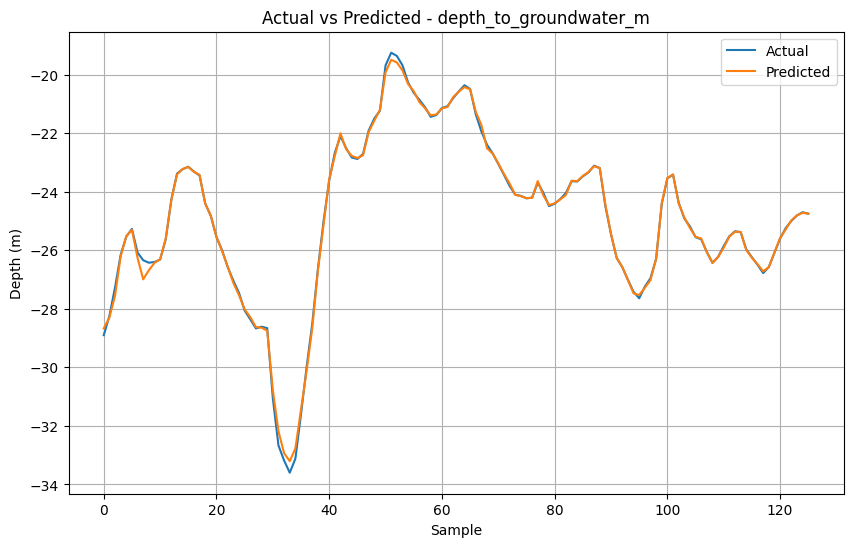

In [12]:
if __name__ == "__main__":
    main()